In [1]:
import pandas as pd
import statistics as stats
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from datetime import timedelta

In [55]:
edu_loc=r"Education.xls"
pov_loc=r"PovertyEstimates.xls"
case_loc=r"us-counties.csv"
sdi_loc=r"SDI.xlsx"
sdi = pd.read_excel(sdi_loc)
edu = pd.read_excel(edu_loc)
pov = pd.read_excel(pov_loc)

In [56]:
case = pd.read_csv(case_loc)
case_columns=["date","county","state","fips","cases",'deaths']
edu_columns=["FIPS Code","Area name","Percent of adults with a bachelor's degree or higher, 2014-18"]
pov_columns=['FIPStxt', 'Stabr', 'Area_name', 'PCTPOVALL_2018']
case=case[case_columns]
sdi_columns=["county","sdi_score"]
edu=edu[edu_columns]
pov=pov[pov_columns]
edu = edu.rename(columns={"Percent of adults with a bachelor's degree or higher, 2014-18": 'Edu'})

In [65]:
## missing fips in file
case["fips"][case["county"]=="Unknown"]=0
case["fips"][case["county"]=="New York City"]=36061
case["fips"][case["county"]=="Kansas City"]=2000
case["fips"].astype(int)
fips_state=case[["fips","state"]].drop_duplicates()
first_day = case.drop_duplicates('state')[['state','date']]

for i in range(1,10):
    first_day['x'+str(i+1)]= (pd.to_datetime(first_day['date'])+timedelta(days=3*i)).astype('str')
    
day = first_day.rename(columns={"date": 'x1'})


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [85]:
def find_median(state,date):
    df = pd.concat([state,date], axis= 1)
    df.columns.values[1] = "date"
    county_list = pd.merge(df, case, left_on=["date", "state"], right_on=["date", "state"],
                            how="left")
    final_table = pd.merge(county_list, sdi, left_on=["fips"], right_on=["county"],
                           how="left") 
    sdi_median = final_table.groupby(by=["state"])['sdi_score'].median().reset_index()

    return(sdi_median)

In [86]:
case_x =[1]
state = day.iloc[:, 0]
date = day.iloc[:, 1]
sdi_result = find_median(state,date)
sdi_result= sdi_result.rename(columns={"sdi_score": 'sdi-first day'})


In [87]:
for i in range(2,day.shape[1]):
    case_x.append(1+(i-1)*3)
    date = day.iloc[:, i]
    sdi_re = find_median(state,date)
    sdi_re= sdi_re.rename(columns={"sdi_score": 'sdi-'+str(1+(i-1)*3)+'th day'})
    sdi_result = sdi_result.merge(sdi_re, on =['state'],how="left")

In [88]:
sdi_result.head()

,state,sdi-first day,sdi-4th day,sdi-7th day,sdi-10th day,sdi-13th day,sdi-16th day,sdi-19th day,sdi-22th day,sdi-25th day,sdi-28th day
0,Alabama,58.0,43.5,59.0,55.0,57.0,58.0,59.0,NaN,NaN,NaN
1,Alaska,35.0,35.0,33.5,33.5,30.5,30.5,30.5,NaN,NaN,NaN
2,Arizona,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0
3,Arkansas,83.0,69.5,58.5,55.5,55.5,56.0,55.0,56.0,NaN,NaN
4,California,53.0,72.5,53.0,55.5,55.5,55.5,58.0,58.0,58.0,63.0


In [76]:
sdi_result.to_csv(r"sdi_result_day.csv",index=False)

In [81]:
mean_day = sdi_result.mean(axis = 0)
median_day = sdi_result.median(axis = 0)
stat = pd.concat([mean_day,median_day],axis=1).reset_index(drop=True)
stat.rename(columns={'0': 'mean','1':'median'},inplace = True)
stat

,0,1
0,44.173333,39.000000
1,42.951742,35.416667
2,41.736284,35.437500
3,41.390112,34.000000
4,41.838287,35.718788
5,41.821721,36.399425
6,41.946567,35.216216
7,42.269805,37.910714
8,41.883918,38.250000
9,44.935317,46.540000


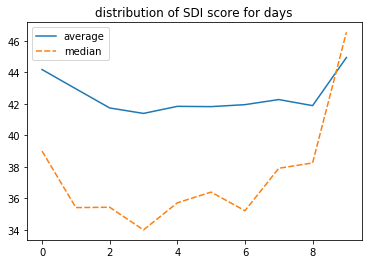

In [82]:
import seaborn as sns
fig, ax = plt.subplots()
g = sns.lineplot(data=stat)
legend = ax.legend()
legend.texts[0].set_text("average")
legend.texts[1].set_text("median")
g.set_title('distribution of SDI score for days')
g.get_figure().savefig("sdi_days.png")

In [83]:
##regression
df_day = pd.DataFrame({ 'x' : case_x,
    'mean' : mean_day,'median': median_day})
df_day.head()

,x,mean,median
sdi-first day,1,44.173333,39.000000
sdi-4th day,4,42.951742,35.416667
sdi-7th day,7,41.736284,35.437500
sdi-10th day,10,41.390112,34.000000
sdi-13th day,13,41.838287,35.718788


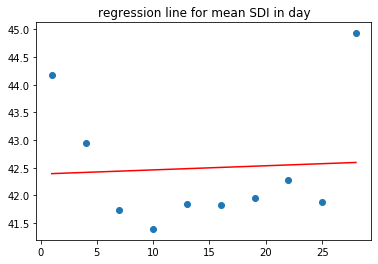

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.121
Method:                 Least Squares   F-statistic:                   0.02693
Date:                Wed, 13 May 2020   Prob (F-statistic):              0.874
Time:                        12:08:33   Log-Likelihood:                -15.243
No. Observations:                  10   AIC:                             34.49
Df Residuals:                       8   BIC:                             35.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.3862      0.769     55.123      0.0

//anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [84]:
X = df_day.iloc[:, 0].values.reshape(-1, 1)
Y = df_day.iloc[:, 1].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.title('regression line for mean SDI in day')
plt.show()
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())